## <center style="color:red;">**BrainScan – Détection du Cancer Cérébral par CNN**</center>

<br>

### <span style="color:green;">**Conception du Modèle CNN :**</span>

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.utils import plot_model
import time
import joblib as jbl

variables = jbl.load("../util/variables.pkl")

X_train = variables["X_train"]
y_train = variables["y_train"]
X_test = variables["X_test"]
y_test = variables["y_test"]
images = variables["images"]
labels = variables["labels"]
encoder = variables["encoder"]
labels_names = variables["labels_names"]

print("Variables importées avec succès !")

Variables importées avec succès !


#### <span style="color:blue;">**1. Définir l’architecture du modèle CNN :**</span>

``Un modèle CNN`` (**Convolutional Neural Network**) est un type de réseau de neurones profond particulièrement efficace pour le traitement d’images et de données structurées en grille (comme les vidéos ou les images médicales). Voici une explication complète.

**A. À quoi sert un ``CNN`` ?**

Un ``CNN`` est utilisé pour extraire automatiquement des caractéristiques (features) d’images et effectuer des tâches comme :

- Classification d’images : reconnaître des objets (ex. chat, chien).

- Détection d’objets : localiser plusieurs objets dans une image.

- Segmentation d’images : identifier les pixels appartenant à différentes classes.

- Reconnaissance faciale et biométrie.

- Analyse médicale : détection de tumeurs ou anomalies sur des IRM ou radiographies.

_**L’avantage principal :**_ pas besoin d’extraire manuellement les caractéristiques (comme avec SVM ou KNN classique). Le ``CNN`` apprend lui-même les motifs.

<br>

**B. Architecture générale d’un ``CNN`` :**

Un ``CNN`` est composé de couches empilées qui transforment progressivement l’image en représentations de plus en plus abstraites.

- **Input Layer :** Reçoit l’image brute (ex. 224x224x3 pour une image couleur).

- **Convolutional Layer (Conv2D) :** 
    
    - Applique des filtres (kernels) pour détecter des motifs locaux (bords, textures…).

    - Il donne comme résultat : feature maps (cartes de caractéristiques).

- **Activation Layer (ReLU, etc.) :** 

    - Introduit la non-linéarité pour permettre au réseau de capturer des motifs complexes.

    - ReLU (Rectified Linear Unit) est le plus courant : remplace les valeurs négatives par 0.

- **Pooling Layer (MaxPooling / AveragePooling) :**

    - Réduit la taille des feature maps (downsampling) pour diminuer le nombre de paramètres et éviter l’overfitting.

    - ``MaxPooling`` : prend la valeur maximale dans une zone.

    - ``AveragePooling`` : prend la moyenne.

- **Dropout Layer (optionnel) :** Évite le surapprentissage en désactivant aléatoirement certains neurones pendant l’entraînement.

- **Flatten Layer :** Transforme les feature maps 2D en vecteur 1D pour passer à la couche dense.

- **Fully Connected Layer (Dense Layer) :**

    - Les couches classiques d’un réseau de neurones.

    - Permet de combiner les caractéristiques extraites et faire la classification finale.

- **Output Layer :**

    - Selon le type de tâche :

        - Classification binaire : 1 neurone avec sigmoid.

        - Classification multiple : n neurones avec softmax.

##### **1.1. Créer le modèle avec des couches Conv2D, MaxPooling, Dropout, Dense :**

```bash
model = models.Sequential([
```

- ``model`` : variable qui va contenir notre modèle de réseau de neurones.

- ``models.Sequential`` : type de modèle Keras où les couches sont empilées les unes après les autres dans un ordre séquentiel.

- ``[ … ]`` : liste des couches du réseau.

<br>

**Couche 1 : Convolution + ReLU + MaxPooling :**

```bash
layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
```

- ``layers.Conv2D`` : couche de convolution 2D, utilisée pour détecter des motifs (bords, textures, formes) dans les images.

- ``32`` : nombre de filtres (ou ``kernels``), donc 32 cartes de caractéristiques seront extraites.

- ``(3, 3)`` : taille du kernel (filtre) = ``3x3`` pixels.

- ``activation='relu'`` : fonction d’activation ReLU (``Rectified Linear Unit``) : transforme toutes les valeurs négatives en 0 et laisse les positives.

- ``input_shape=(224, 224, 3)`` : forme des images d’entrée : ``224x224`` pixels avec 3 canaux (R, G, B).

```bash
layers.MaxPooling2D((2, 2)),
```

- ``layers.MaxPooling2D`` : couche de max pooling, qui réduit la dimension spatiale de l’image (hauteur et largeur) pour diminuer le calcul et extraire les caractéristiques principales.

- ``(2, 2)`` : taille de la fenêtre de pooling = ``2x2``.

<br>

**Couche 2 : Convolution + ReLU + MaxPooling :**

```bash
layers.Conv2D(64, (3, 3), activation='relu'),
layers.MaxPooling2D((2, 2)),
```

- Même principe que la couche précédente.

- 64 filtres cette fois : plus de cartes de caractéristiques pour capturer des motifs plus complexes.

- Pas besoin de input_shape ici car Keras connaît déjà la taille de l’entrée de cette couche à partir de la couche précédente.

<br>

**Couche 3 : Convolution + ReLU + MaxPooling :**

```bash
layers.Conv2D(128, (3, 3), activation='relu'),
layers.MaxPooling2D((2, 2)),
```

- Toujours le même principe.

- ``128 filtres`` : extraction de motifs encore plus complexes.

<br>

**Dropout pour éviter le surapprentissage :**

```bash
layers.Dropout(0.3),
```

- ``layers.Dropout`` : couche qui éteint aléatoirement un pourcentage de neurones pendant l’entraînement pour éviter le surapprentissage (overfitting).

- ``0.3`` : 30% des neurones sont désactivés à chaque itération.

<br>

**Couche Flatten pour aplatir les cartes de caractéristiques :**

```bash
layers.Flatten(),
```

- ``layers.Flatten`` : transforme les cartes 2D en un vecteur 1D pour les passer aux couches denses (fully connected).

- Exemple : si les cartes sont de taille (28, 28, 128) -> flatten -> vecteur de taille ``28*28*128 = 100352``.

<br>

**Couche Dense cachée :**

```bash
layers.Dense(128, activation='relu'),
```

- ``layers.Dense`` : couche entièrement connectée (chaque neurone est relié à tous les neurones de la couche précédente).

- ``128`` : nombre de neurones dans cette couche.

- ``activation='relu'`` : fonction ReLU pour introduire la non-linéarité.

<br>

**Dropout supplémentaire :**

```bash
layers.Dropout(0.3),
```

- Encore un dropout de 30% pour éviter le surapprentissage après la couche dense.

<br>

**Couche de sortie :**

```bash
layers.Dense(y_train.shape[1], activation='softmax')
```

- ``layers.Dense`` : couche entièrement connectée pour la sortie.

- ``y_train.shape[1]`` : nombre de neurones = nombre de classes à prédire (ex : 4 classes : 4 neurones).

- ``activation='softmax'`` : fonction softmax -> transforme les valeurs en probabilités (somme = 1), adaptée à la classification multi-classes.

In [22]:
model = models.Sequential([
    Input(shape=(224, 224, 3)),
    # Couche 1 : Convolution + ReLU + MaxPooling
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Couche 2 : Convolution + ReLU + MaxPooling
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Couche 3 : Convolution + ReLU + MaxPooling
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Dropout pour éviter le surapprentissage
    layers.Dropout(0.3),
    
    # Couche Flatten pour aplatir les cartes de caractéristiques
    layers.Flatten(),
    
    # Couche Dense cachée
    layers.Dense(128, activation='relu'),
    
    # Dropout supplémentaire
    layers.Dropout(0.3),
    
    # Couche de sortie (nombre de neurones = nombre de classes)
    layers.Dense(y_train.shape[1], activation='softmax')  # Softmax pour classification multi-classes
])

##### **1.2. Afficher l’architecture du modèle avec model.summary() et plot_model() :**

La méthode ``summary()`` affiche le résumé de l’architecture de ton modèle, c’est-à-dire :

- Les types de couches (Conv2D, MaxPooling, Dense, Dropout, etc.)

- Les tailles des sorties de chaque couche

- Le nombre de paramètres entraînables (weights + biais)

- Le nombre total de paramètres du modèle

In [23]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

La fonction ``tensorflow.keras.utils.plot_model()`` sert à générer un diagramme de ton modèle (fichier image ou affichage direct).

Elle aide à visualiser la structure du réseau, avec les couches, leurs connexions, et les tailles de sorties de chaque couche.

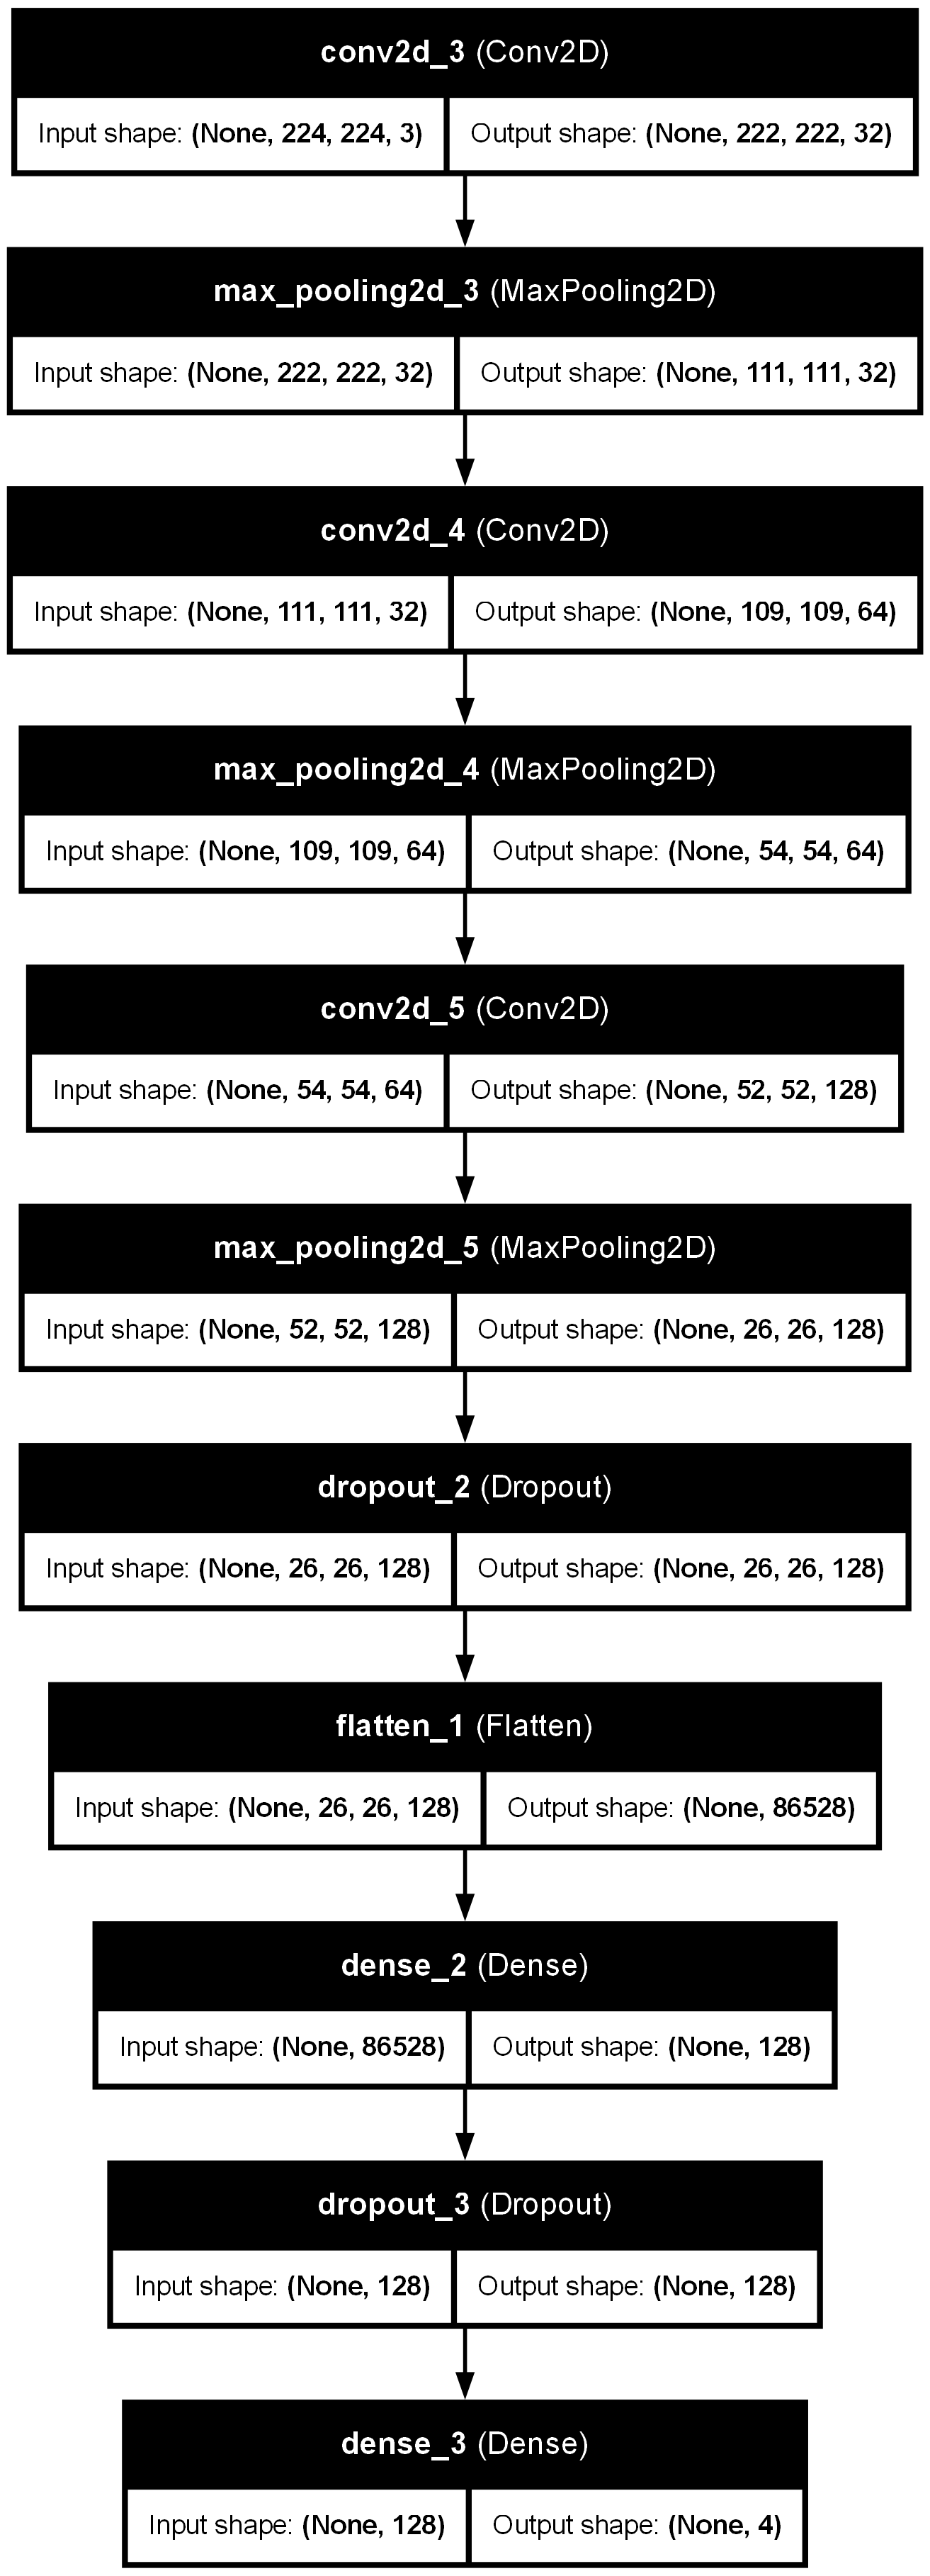

In [24]:
from tensorflow.keras.utils import plot_model

plot_model(
    model,
    to_file="../architecture/cnn_model_architecture.png",
    show_shapes=True,
    show_layer_names=True
)

#### <span style="color:blue;">**2. Optimiser la compilation du modèle :**</span>

##### **2.1. Définir l’optimiseur (Adam) :**

Quand notre CNN apprend, il essaie de minimiser une fonction de perte (par exemple ``categorical_crossentropy`` pour la classification multi-classes).

L’optimiseur est l’algorithme qui décide comment ajuster les poids du modèle à chaque étape pour réduire l’erreur.

**Comment Adam fonctionne ?**

- ``Adam`` = Adaptive Moment Estimation

- C’est une combinaison de deux optimisateurs célèbres :

    - ``Momentum`` : garde une ``mémoire`` de la direction du gradient passé (pour éviter de zigzaguer)

    - ``RMSProp`` : adapte le taux d’apprentissage individuellement pour chaque paramètre

En d’autres mots, Adam est rapide, stable et automatique : Il ajuste dynamiquement le learning rate pour chaque poids du réseau.

**Les équations internes (simplifiées) :**

À chaque itération :

1. Adam calcule le gradient (la pente de l’erreur).

2. Il maintient deux moyennes :

    - ``m`` : moyenne du gradient (``momentum``)

    - ``v`` : moyenne du carré du gradient (pour l’adaptation du learning rate)

3. Il met à jour les poids selon :

$$
w = w - \alpha * (m / (\sqrt(v) + \epsilon))
$$

où :

- $\alpha$ = learning rate (par défaut 0.001).

- $\epsilon$ = petite valeur pour éviter la division par zéro.

In [25]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

##### **2.2. Choisir la fonction de perte (categorical_crossentropy) :**

La fonction de perte mesure à quel point le modèle se trompe.

Elle calcule la différence entre la prédiction du modèle et la valeur réelle (vraie étiquette).

L’objectif du modèle pendant l’entraînement est de minimiser cette perte grâce à l’optimiseur (comme Adam).

**Pourquoi ``categorical_crossentropy`` ?**

Parce que le modèle prédit plusieurs classes (ex : ``glioma``, ``meningioma``, ``notumor``, ``pituitary``).

Donc :

- la sortie est un vecteur de probabilités via softmax (ex : [0.8, 0.1, 0.05, 0.05])

- la vérité terrain (``y_train``) est one-hot encodée (ex : [1, 0, 0, 0])

``categorical_crossentropy`` mesure à quel point les deux distributions diffèrent.

**Formule mathématique simplifiée :**

Pour un exemple avec 4 classes :

$$
Loss = - \sum_{i=1}^{4} y_i * \log{(\hat{y_i})}
$$

Où :

- $y_i$ = vraie valeur (1 pour la bonne classe, 0 sinon)

- $\hat{y_i}$ = probabilité prédite par le modèle pour la classe i

In [26]:
loss_function = 'categorical_crossentropy'

##### **2.3. Définir les métriques à suivre (accuracy) :**

In [27]:
metric = ['accuracy']

##### **2.4. Compilation du modèle :**

``model.compile()`` prépare ton modèle pour l’entraînement.

Elle dit à Keras :

- Quel optimiseur utiliser : comment mettre à jour les poids (``Adam``, ``SGD``, etc.)

- Quelle fonction de perte utiliser : comment mesurer l’erreur (``categorical_crossentropy``, ``mse``, etc.)

- Quelles métriques suivre : pour observer la performance (``accuracy``, ``precision``, etc.)

Sans compiler le modèle, tu ne peux pas l’entraîner avec ``model.fit()``.

In [28]:
model.compile(
    optimizer=adam_optimizer,
    loss=loss_function,
    metrics=metric
)

##### **2.5. Définir les Hyperparamètres :**

Le ``batch_size`` est le nombre d’exemples traités avant que le modèle mette à jour ses poids.

- Dans la descente de gradient, on calcule les gradients pour ajuster les poids.

- Batch size = combien d’exemples tu utilises pour calculer une seule mise à jour des poids.

**Trois types d’apprentissage selon le batch size :**

| Type                                  | Description                                                                                                                                                              |
| ------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| Batch Gradient Descent            | Le modèle utilise tout le dataset pour calculer les gradients → très lent si dataset énorme                                                                          |
| Stochastic Gradient Descent (SGD) | Le modèle utilise 1 exemple à la fois → mise à jour très fréquente mais bruitée                                                                                      |
| Mini-Batch Gradient Descent       | Le modèle utilise un petit sous-ensemble (batch) → meilleur compromis entre rapidité et stabilité. C’est ce qu’on utilise généralement (`batch_size=32, 64, 128...`) |


In [29]:
batch_size = 32

Une epoch est un passage complet sur tout le dataset d’entraînement.

- Autrement dit, toutes les images de ton dataset sont vues une fois par le modèle pour ajuster les poids.

- En pratique, tu entraînes généralement ton modèle sur plusieurs epochs pour que le modèle apprenne correctement.

**Exemple concret :**

Supposons :

- ``X_train`` = 1000 images

- ``batch_size`` = 100

- ``epochs`` = 20

Alors :

- Chaque epoch = 1000 images traitées

- Nombre de batches par epoch = 1000 ÷ 100 = 10 batches

- Après chaque batch, les poids sont mis à jour

- Après 1 epoch → toutes les images ont été utilisées une fois

- Après 20 epochs → toutes les images ont été utilisées 20 fois

In [30]:
epochs = 20

#### <span style="color:blue;">**3. Entraîner le modèle sur le dataset préparé :**</span>

##### **3.1. Callback pour sauvegarder le meilleur modèle :**

- Pendant l’entraînement, le modèle voit plusieurs epochs et ses poids changent à chaque batch.

- Si le modèle apprend bien, tu veux sauvegarder la meilleure version (celle avec la meilleure performance sur les données de validation).

- ModelCheckpoint permet de sauvegarder automatiquement :

    - Le modèle entier (architecture + poids) ou seulement les poids.

    - A chaque epoch ou uniquement quand la performance s’améliore.

**Options importantes :**

| Paramètre           | Utilité                                                            |
| ------------------- | ------------------------------------------------------------------ |
| `filepath`          | Nom du fichier pour sauvegarder le modèle                          |
| `monitor`           | Quelle métrique suivre (`val_loss`, `val_accuracy`, etc.)          |
| `save_best_only`    | Sauvegarder seulement quand la métrique s’améliore                 |
| `save_weights_only` | Sauvegarder juste les poids ou tout le modèle                      |
| `mode`              | 'min' si on veut minimiser la métrique, 'max' si on veut maximiser |
| `verbose`           | 1 : affiche un message, 0 : silencieux                             |


In [31]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    '../models/best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

##### **3.2. Entraîner le modèle :**

In [32]:
start_time = time.time()

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[checkpoint],
    verbose=1
)

training_time = time.time() - start_time
print(f"\nDurée totale d'entraînement : {training_time:.2f} secondes")

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.5641 - loss: 1.0780
Epoch 1: val_accuracy improved from None to 0.80125, saving model to ../models/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 74s 360ms/step - accuracy: 0.6844 - loss: 0.7676 - val_accuracy: 0.8012 - val_loss: 0.5087
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.8329 - loss: 0.4224
Epoch 2: val_accuracy improved from 0.80125 to 0.88625, saving model to ../models/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 78s 392ms/step - accuracy: 0.8417 - loss: 0.4012 - val_accuracy: 0.8863 - val_loss: 0.3221
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9036 - loss: 0.2579
Epoch 3: val_accuracy improved from 0.88625 to 0.89062, saving model to ../models/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 77s 368ms/step - accuracy: 0.8952 - loss: 0.2652 - val_accuracy: 0.8906 - val_loss: 0.3067
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.9366 - loss: 0.1699
Epoch 4: val_accuracy improved from 0.89062 to 0.90188, saving model to ../models/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 77s 383ms/step - accuracy: 0.9331 - loss: 0.1768 - val_accuracy: 0.9019 - val_loss: 0.3014
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.9460 - loss: 0.1422
Epoch 5: val_accuracy improved from 0.90188 to 0.91438, saving model to ../models/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 80s 371ms/step - accuracy: 0.9470 - loss: 0.1346 - val_accuracy: 0.9144 - val_loss: 0.2651
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9683 - loss: 0.0828
Epoch 6: val_accuracy improved from 0.91438 to 0.92188, saving model to ../models/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 83s 378ms/step - accuracy: 0.9620 - loss: 0.0962 - val_accuracy: 0.9219 - val_loss: 0.2586
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.9802 - loss: 0.0585
Epoch 7: val_accuracy improved from 0.92188 to 0.92750, saving model to ../models/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 77s 385ms/step - accuracy: 0.9783 - loss: 0.0589 - val_accuracy: 0.9275 - val_loss: 0.3094
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.9811 - loss: 0.0612
Epoch 8: val_accuracy improved from 0.92750 to 0.93000, saving model to ../models/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 75s 374ms/step - accuracy: 0.9795 - loss: 0.0602 - val_accuracy: 0.9300 - val_loss: 0.2718
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.9854 - loss: 0.0429
Epoch 9: val_accuracy did not improve from 0.93000
200/200 ━━━━━━━━━━━━━━━━━━━━ 74s 336ms/step - accuracy: 0.9831 - loss: 0.0482 - val_accuracy: 0.9081 - val_loss: 0.3369
Epoch 10/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.9823 - loss: 0.0496
Epoch 10: val_accuracy did not improve from 0.93000
200/200 ━━━━━━━━━━━━━━━━━━━━ 71s 354ms/step - accuracy: 0.9784 - loss: 0.0597 - val_accuracy: 0.9225 - val_loss: 0.2736
Epoch 11/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9876 - loss: 0.0368
Epoch 11: val_accuracy did not improve from 0.93000
200/200 ━━━━━━━━━━━━━━━━━━━━ 70s 349ms/step - accuracy: 0.9880 - loss: 0.0336 - val_accuracy: 0.9219 - val_loss: 0.3506
Epoch 12/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9904 - loss: 0.0250
Epoch 12: 

200/200 ━━━━━━━━━━━━━━━━━━━━ 68s 342ms/step - accuracy: 0.9900 - loss: 0.0316 - val_accuracy: 0.9325 - val_loss: 0.3686
Epoch 18/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.9942 - loss: 0.0192
Epoch 18: val_accuracy did not improve from 0.93250
200/200 ━━━━━━━━━━━━━━━━━━━━ 61s 307ms/step - accuracy: 0.9933 - loss: 0.0218 - val_accuracy: 0.9256 - val_loss: 0.3754
Epoch 19/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9933 - loss: 0.0207
Epoch 19: val_accuracy did not improve from 0.93250
200/200 ━━━━━━━━━━━━━━━━━━━━ 61s 304ms/step - accuracy: 0.9950 - loss: 0.0160 - val_accuracy: 0.9237 - val_loss: 0.4102
Epoch 20/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9946 - loss: 0.0162
Epoch 20: val_accuracy did not improve from 0.93250
200/200 ━━━━━━━━━━━━━━━━━━━━ 60s 302ms/step - accuracy: 0.9934 - loss: 0.0175 - val_accuracy: 0.9262 - val_loss: 0.4224

Durée totale d'entraînement : 1430.75 secondes


<br>

#### <span style="color:blue;">**4. Evaluer les performances du modèle :**</span>

##### **4.1. Évaluer avec model.evaluate() :**

In [33]:
model.load_weights('../models/best_model.h5')
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nPrécision sur l'ensemble de test : {test_acc*100:.2f}%")


Précision sur l'ensemble de test : 93.25%


##### **4.2. Afficher les courbes d’apprentissage :**

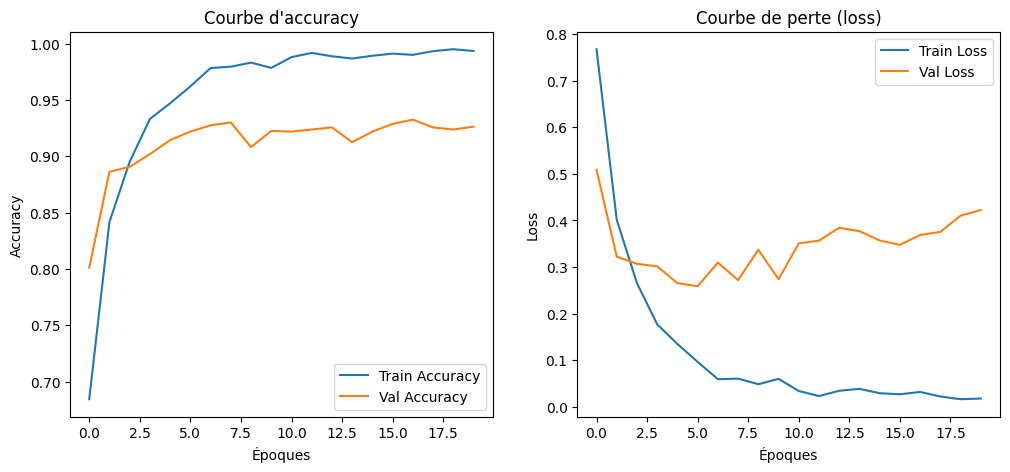

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Courbe d'accuracy")
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Courbe de perte (loss)")
plt.xlabel('Époques')
plt.ylabel('Loss')
plt.legend()
plt.show()

##### **4.3. Générer une matrice de confusion :**

50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step


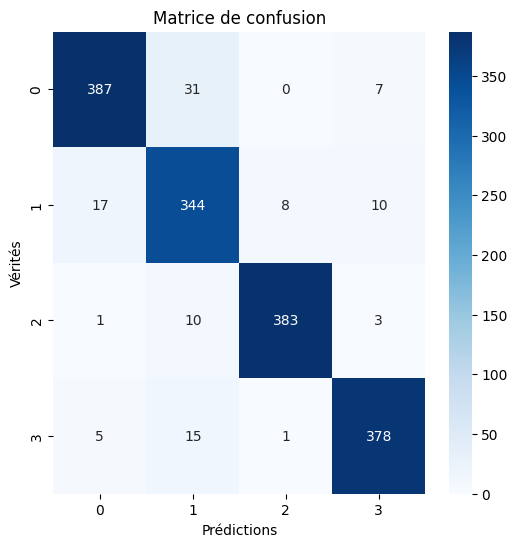

In [35]:
import numpy as np
import time
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.show()

##### **4.4. Générer un rapport de classification :**

In [36]:
import pandas as pd
print("\nRapport de classification :")

report = classification_report(y_true, y_pred_classes, output_dict=True)

print(classification_report(y_true, y_pred_classes))

df_report = pd.DataFrame(report).transpose()

df_report.to_csv("../performance/model_performance.csv", index=True)



Rapport de classification :
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       425
           1       0.86      0.91      0.88       379
           2       0.98      0.96      0.97       397
           3       0.95      0.95      0.95       399

    accuracy                           0.93      1600
   macro avg       0.93      0.93      0.93      1600
weighted avg       0.93      0.93      0.93      1600



##### **4.5. Montrer des exemples de prédictions correctes et incorrecte :**

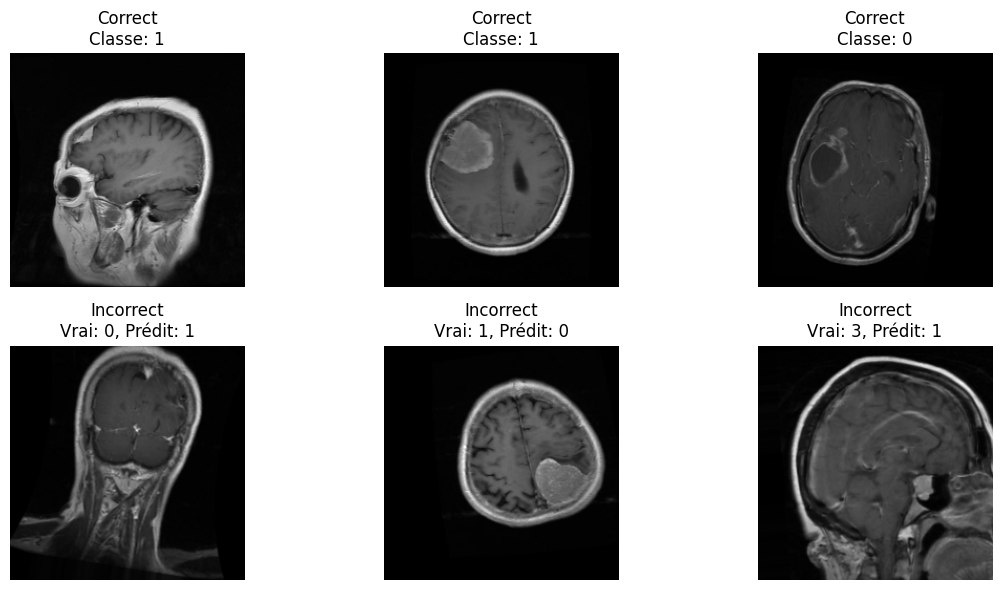

In [37]:
correct = np.where(y_pred_classes == y_true)[0]
incorrect = np.where(y_pred_classes != y_true)[0]

plt.figure(figsize=(12,6))
for i, idx in enumerate(correct[:3]):
    plt.subplot(2,3,i+1)
    plt.imshow(X_test[idx])
    plt.title(f"Correct\nClasse: {np.argmax(y_test[idx])}")
    plt.axis('off')

for i, idx in enumerate(incorrect[:3]):
    plt.subplot(2,3,i+4)
    plt.imshow(X_test[idx])
    plt.title(f"Incorrect\nVrai: {np.argmax(y_test[idx])}, Prédit: {y_pred_classes[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()